In [1]:
import torch
import numpy as np
import math
import gpytorch
from matplotlib import pyplot as plt

# Generating synthetic train_x with shape [100, 43]
num_points = 100
num_features = 43
train_x = torch.rand(num_points, num_features)

# Generating synthetic train_y with shape [100, 3]
train_y = torch.stack([
    torch.sin(2 * math.pi * train_x[:, 0]) + torch.randn(num_points) * 0.2,
    torch.cos(2 * math.pi * train_x[:, 0]) + torch.randn(num_points) * 0.2,
    torch.sin(4 * math.pi * train_x[:, 0]) + torch.randn(num_points) * 0.2,
], -1)


In [10]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_features)
        )
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=3, rank=1)

    def forward(self, x):
        print("x:",x.shape)
        mean_x = self.mean_module(x)
        print("mean_x",mean_x.shape)
        covar_x = self.covar_module(x) * self.task_covar_module(x)
        print("covar_x",covar_x.shape)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [12]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.size(-1))
        )
        # Multitask kernel for handling the tasks
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=3, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        # Ensure covar_x is combined with a task-specific kernel
        covar_x = self.covar_module(x)
        covar_task = self.task_covar_module(torch.zeros(x.size(0)))
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x + covar_task.covariance_matrix)


In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.size(-1))
        )
        # Assuming num_tasks is defined (e.g., 3 for your case)
        self.num_tasks = train_y.size(-1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        print("mean_x",mean_x.shape)
        # Replicate mean to match the number of tasks
        mean_x = mean_x.expand(x.size(0), self.num_tasks)
        print("mean_x",mean_x.shape)
        covar_x = self.covar_module(x)
        print("covar_x",covar_x.shape)
        # Assuming you have a task_covar_module defined correctly to handle the multitask scenario
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [5]:
# Assume train_x and train_y are defined as above

# Define the likelihood and model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
model = MultitaskGPModel(train_x, train_y, likelihood)

# Training loop setup (as per your provided code)
# Note: This code assumes the existence of a compatible MultitaskGPModel definition

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

for i in range(50):  # Adjust the number of iterations as needed
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:  # Print every 10 iterations
        print(f'Iter {i + 1}/50 - Loss: {loss.item()}')

# Switch to evaluation mode
model.eval()
likelihood.eval()

# Prediction code remains similar; adjust as needed for your specific use case


mean_x torch.Size([100])


RuntimeError: The expanded size of the tensor (3) must match the existing size (100) at non-singleton dimension 1.  Target sizes: [100, 3].  Tensor sizes: [100]

In [5]:
autoencoder = mymodel.SmallerFlexibleCNNAutoencoder((1,96,72), bottleneck_size=40).to(device)
# Step 3: Train the autoencoder
model_path_autoencoder = f'/home/swang597/Documents/Research/Project_heightmap/Model/Autoencoder/SmallerFlexibleCNNAutoencoder/best_model_bottleneck_40_seed21995_epoch4982_loss0.000005.pth'
# load the best model
autoencoder.load_state_dict(torch.load(model_path_autoencoder))

RF_HM_init_test_train = autoencoder.encode(HM_init_test_train.to(device))
RF_HM_init_test_test = autoencoder.encode(HM_init_test_test.to(device))

wheel_state_test_test = wheel_state_test_test.to(device)
wheel_state_test_train = wheel_state_test_train.to(device)

print("RF_HM_init_test_train.shape:",RF_HM_init_test_train.shape, "RF_HM_init_test_test.shape",RF_HM_init_test_test.shape)
print("wheel_state_test_train.shape",wheel_state_test_train.shape,"wheel_state_test_test.shape:",wheel_state_test_test.shape)

RF_HM_init_test_train.shape: torch.Size([25116, 40]) RF_HM_init_test_test.shape torch.Size([6279, 40])
wheel_state_test_train.shape torch.Size([25116, 3]) wheel_state_test_test.shape: torch.Size([6279, 3])


In [6]:
input_features_train = torch.cat((RF_HM_init_test_train, wheel_state_test_train), dim=1)
input_features_test = torch.cat((RF_HM_init_test_test, wheel_state_test_test), dim=1)
# np.concatenate([RF_HM_init_test_train, wheel_state_test_train], axis=1)  # Shape: (num_samples, n + 4)
# input_features_test = np.concatenate([RF_HM_init_test_test, wheel_state_test_test], axis=1)  # Shape: (num_samples, n + 4)
print("input_features_train.shape",input_features_train.shape, "input_features_test.shape", input_features_test.shape)
print("FN_test_train.shape",FN_test_train.shape, "FN_test_test.shape",FN_test_test.shape)

input_features_train.shape torch.Size([25116, 43]) input_features_test.shape torch.Size([6279, 43])


FN_test_train.shape torch.Size([25116, 3]) FN_test_test.shape torch.Size([6279, 3])


Iter 1/50 - Loss: 1.237
Iter 2/50 - Loss: 1.199
Iter 3/50 - Loss: 1.157
Iter 4/50 - Loss: 1.113
Iter 5/50 - Loss: 1.068
Iter 6/50 - Loss: 1.022
Iter 7/50 - Loss: 0.977
Iter 8/50 - Loss: 0.933
Iter 9/50 - Loss: 0.889
Iter 10/50 - Loss: 0.848
Iter 11/50 - Loss: 0.808
Iter 12/50 - Loss: 0.770
Iter 13/50 - Loss: 0.732
Iter 14/50 - Loss: 0.694
Iter 15/50 - Loss: 0.656
Iter 16/50 - Loss: 0.618
Iter 17/50 - Loss: 0.579
Iter 18/50 - Loss: 0.540
Iter 19/50 - Loss: 0.500
Iter 20/50 - Loss: 0.460
Iter 21/50 - Loss: 0.420
Iter 22/50 - Loss: 0.380
Iter 23/50 - Loss: 0.341
Iter 24/50 - Loss: 0.303
Iter 25/50 - Loss: 0.266
Iter 26/50 - Loss: 0.231
Iter 27/50 - Loss: 0.198
Iter 28/50 - Loss: 0.167
Iter 29/50 - Loss: 0.138
Iter 30/50 - Loss: 0.111
Iter 31/50 - Loss: 0.085
Iter 32/50 - Loss: 0.062
Iter 33/50 - Loss: 0.040
Iter 34/50 - Loss: 0.020
Iter 35/50 - Loss: 0.004
Iter 36/50 - Loss: -0.010
Iter 37/50 - Loss: -0.020
Iter 38/50 - Loss: -0.028
Iter 39/50 - Loss: -0.034
Iter 40/50 - Loss: -0.037
Iter

/home/swang597/Documents/Package/anaconda3/envs/pytorch_cuda12.1/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


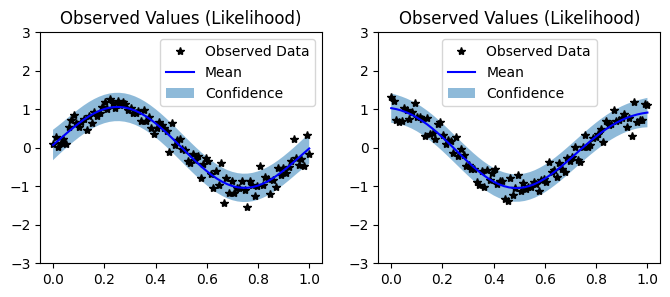

In [ ]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task


In [ ]:

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')
plt.show()